# [2.X코드반영] Lab 11-2: mnist cnn keras functional eager


## Importing Libraries

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.0


## Hyper Parameters

In [4]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100
tf.random.set_seed(777)

## Creating a Checkpoint Directory

In [5]:
cur_dir = os.getcwd()
ckpt_dir_name = 'checkpoints'
model_dir_name = 'mnist_cnn_seq'

checkpoint_dir = os.path.join(cur_dir, ckpt_dir_name, model_dir_name)
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, model_dir_name)

## MNIST/Fashion MNIST Data

In [6]:
mnist = keras.datasets.mnist
class_names = ['0','1','2','3','4','5','6','7','8','9']

## Datasets

In [7]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.astype(np.float32)/255.
test_images = test_images.astype(np.float32)/255.

train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size = 1000000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

11493376/11490434 [==============================] - 0s 0us/step


## Model Function(Functional API)

In [20]:
def create_model_F():
  inputs = keras.Input(shape=(28,28,1))
  conv1 = keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu, padding='SAME')(inputs)
  pool1 = keras.layers.MaxPool2D(padding='SAME')(conv1)
  conv2 = keras.layers.Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu, padding='SAME')(pool1)
  pool2 = keras.layers.MaxPool2D(padding='SAME')(conv2)
  conv3 = keras.layers.Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu, padding='SAME')(pool2)
  pool3 = keras.layers.MaxPool2D(padding='SAME')(conv3)
  pool3_flat = keras.layers.Flatten()(pool3)
  dense4 = keras.layers.Dense(units=256, activation=tf.nn.relu)(pool3_flat)
  drop4 = keras.layers.Dropout(rate=0.4)(dense4)
  logits = keras.layers.Dense(units=10)(drop4)
  return keras.Model(inputs=inputs, outputs=logits)

In [21]:
model = create_model_F()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 128)         0   

## Loss Function

In [22]:
@tf.function
def loss_fn(model, images, labels):
  logits = model(images, training=True)
  loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(
      y_pred=logits, y_true=labels, from_logits=True))
  return loss

## Calculating Gradient

In [23]:
@tf.function
def grad(model, images, labels):
  with tf.GradientTape() as tape:
    loss = loss_fn(model, images, labels)
  return tape.gradient(loss, model.variables)

## Caculating Model's Accuracy

In [24]:
@tf.function
def evaluate(model, images, labels):
  logits = model(images, training=False)
  correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(labels, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  return accuracy

## Optimizer

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

## Creating a Checkpoint

In [26]:
checkpoint = tf.train.Checkpoint(cnn=model)

## Training  - Functional API

In [27]:
@tf.function
def train(model, images, labels):
  grads = grad(model, images, labels)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [28]:
# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    train_step = 0
    test_step = 0    
    
    for images, labels in train_dataset:
        train(model, images, labels)
        loss = loss_fn(model, images, labels)
        acc = evaluate(model, images, labels)
        avg_loss = avg_loss + loss
        avg_train_acc = avg_train_acc + acc
        train_step += 1
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_train_acc / train_step
    
    for images, labels in test_dataset:        
        acc = evaluate(model, images, labels)        
        avg_test_acc = avg_test_acc + acc
        test_step += 1    
    avg_test_acc = avg_test_acc / test_step    

    print('Epoch:', '{}'.format(epoch + 1), 'loss =', '{:.8f}'.format(avg_loss), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))
    
    checkpoint.save(file_prefix=checkpoint_prefix)

print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 1 loss = 0.16501844 train accuracy =  0.9579 test accuracy =  0.9872
Epoch: 2 loss = 0.04074861 train accuracy =  0.9900 test accuracy =  0.9884
Epoch: 3 loss = 0.02677576 train accuracy =  0.9932 test accuracy =  0.9905
Epoch: 4 loss = 0.01959076 train accuracy =  0.9955 test accuracy =  0.9920
Epoch: 5 loss = 0.01337030 train accuracy =  0.9966 test accuracy =  0.9923
Epoch: 6 loss = 0.01174199 train accuracy =  0.9973 test accuracy =  0.9933
Epoch: 7 loss = 0.00934013 train accuracy =  0.9977 test accuracy =  0.9907
Epoch: 8 loss = 0.00803955 train accuracy =  0.9980 test accuracy =  0.9947
Epoch: 9 loss = 0.00706350 train accuracy =  0.9985 test accuracy =  0.9930
Epoch: 10 loss = 0.00409852 train accuracy =  0.9990 test accuracy =  0.9935
Epoch: 11 loss = 0.00440889 train accuracy =  0.9990 test accuracy =  0.9916
Epoch: 12 loss = 0.00345073 train accuracy =  0.9992 test accuracy =  0.9932
Epoch: 13 loss = 0.00321273 train accuracy =  0.

## Residaul block

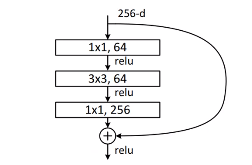

In [34]:
def create_model_R():
  inputs = keras.Input(shape=(28,28,256))
  conv1 = keras.layers.Conv2D(filters=64, kernel_size=1, activation=tf.nn.relu, padding='SAME')(inputs)
  conv2 = keras.layers.Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu, padding='SAME')(conv1)
  conv3 = keras.layers.Conv2D(filters=256, kernel_size=1, activation=tf.nn.relu, padding='SAME')(conv2)
  add3 = keras.layers.add([conv3, inputs])
  relu3 = keras.layers.ReLU()(add3)
  model = keras.Model(inputs=inputs, outputs=logits)